<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation Stage 1
- restrict all spectra onto same wavelengths interval and rescale to common grid
- filter out zwarnings
- enforce weak target selection

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
tf.__version__

'2.2.0'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import pandas as pd

In [7]:
# # ! pip install tensorflow-probability==0.11.0
# ! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

#### load some SDSS data


In [8]:
import sdss_pae.sdss_dataset as sdss 

In [9]:
ds, info = tfds.load('sdss', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_good', with_info=True, split='train', download=True)
tot_num  = info.splits['train'].num_examples

In [10]:
info

tfds.core.DatasetInfo(
    name='sdss',
    full_name='sdss/1.0.0',
    description="""
    selected features from spAll and spZbest files 
    'flux': measured spectrum in  
    'inv_var': inverse variance
    'and_mask': and mask (set to 1 for all non-zero entries)
    'coeffs': c0, c1, npix. calculate wavelengths with `10.**(c0 + c1 * np.arange(npix))`
    'label': type of object, 'STAR'==0, 'QSO'==1, 'GALAXY'==2
    'redshift': object redshift estimate
    """,
    homepage='https://www.sdss.org/science/data-release-publications/',
    data_path='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_good/sdss/1.0.0',
    download_size=Unknown size,
    dataset_size=199.20 GiB,
    features=FeaturesDict({
        'DEC': tf.float32,
        'MJD': tf.int32,
        'RA': tf.float32,
        'and_mask': Tensor(shape=(None, 1), dtype=tf.int32),
        'coeffs': Tensor(shape=(3, 1), dtype=tf.float32),
        'fiber': tf.int32,
        'filename': Text(shape=(), dtype=tf.string),
        'flu

In [11]:
mm = 5


In [12]:
if mm<5:
    ds, info = tfds.load('sdss', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_good',with_info=True, split='train[%d:%d]'%(mm*1000000,(mm+1)*1000000), download=True)
    num_examples = info.splits['train[%d:%d]'%(mm*1000000,(mm+1)*1000000)].num_examples
else:
    ds, info = tfds.load('sdss', data_dir='/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_good',with_info=True, split='train[%d:%d]'%(mm*1000000,tot_num), download=True)
    num_examples = info.splits['train[%d:%d]'%(mm*1000000,tot_num)].num_examples

In [13]:
print(num_examples)

300240


In [14]:
#### settings
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
select_by       = [1,2] 
de_redshift     = True
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)

In [15]:
root_data

'/global/cscratch1/sd/vboehm/Datasets'

In [16]:
#target, MJD_t, plate_t, fiber_t, objid_t = np.load(os.path.join(root_data,'SDSS_BOSS_data/target_selection.npy'))



In [17]:
subselect = pd.read_csv('../PAE_targets.csv')
MJD_t = subselect['mjd']
plate_t = subselect['plate']
fiber_t = subselect['fiberid']

In [18]:
obj = [[MJD_t[ii], plate_t[ii], fiber_t[ii]] for ii in range(len(subselect))]

In [19]:
len(obj)

500000

In [5]:
z_ref  = 0.1
ld_ref = cosmo.luminosity_distance(z_ref)
print(ld_ref)

475.8222675121877 Mpc


In [21]:
# filter dataset by redshifts and type

def filter_type_fn(x):
    if select_by is not None:
        x = x['label']
        s = tf.ones(len(select_by), dtype=tf.int64)*np.asarray(select_by)
        tile_multiples = tf.concat([tf.ones(tf.shape(tf.shape(x)), dtype=tf.int32), tf.shape(s)], axis=0)
        x_tile = tf.tile(tf.expand_dims(x, -1), tile_multiples)
        x_in_s = tf.reduce_any(tf.equal(x_tile, s), -1)
        return x_in_s
    else: return 1
    
def filter_zwarning_fn(x):
    return tf.math.equal(x['zwarning'], 0)

    
def filter_redshift_fn(x):
    return tf.math.greater(x['redshift'], 0)

#ds = ds.filter(filter_type_fn)
ds = ds.filter(filter_redshift_fn)
ds = ds.filter(filter_zwarning_fn)

In [23]:
# DATASET_SIZE=len(list(ds))
# print('size of subselected data:', DATASET_SIZE)

In [22]:
# computing maximum and minimum redhsift in the data sample, getting distribution of data sizes
# this doe not need to be run every time - especially if wavelength range is set by user

try:
    wl_range = np.load('wl_range_%s.npy'%label)
except:
    ii          = 0
    min_wl      = 100
    max_wl      = -100
    num_npixs   = []
    img_coeffs1 = []
    img_coeffs2 = []
    factors     = []
    min_z       = 5
    max_z       = -5
    redshifts   = []

    for image in tfds.as_numpy(ds):
        log10wl = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
        if de_redshift:
            log10wl = log10wl-np.log10(1+image['redshift'])
        if max(log10wl)>max_wl:
            max_wl= max(log10wl)
        if min(log10wl)<min_wl:
            min_wl=min(log10wl)
        redshifts.append(image['redshift'])

    wl_range = (min_wl, max_wl) 

    np.save('wl_range_%s.npy'%label,wl_range)

In [23]:
min_wl, max_wl = wl_range
print(10**min_wl, 10**max_wl)

# compute number of pixels that span entire wl range:
npix_max = -(min_wl-max_wl)/np.unique(1e-4)
print(npix_max)

444.528876727121 10415.635957467819
[13697.85814107]


In [24]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

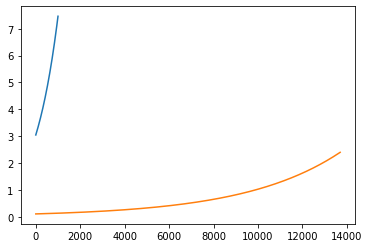

In [25]:
plt.plot(np.diff(new_wl))
plt.plot(np.diff(10**(min_wl+np.arange(npix_max)*1e-4)))

In [26]:
from scipy.stats import binned_statistic

In [27]:
raw_flux           = []
raw_noise          = []
raw_masks          = []
decs               = []
ras                = []
sublabel           = []
plate_id           = []
MJD                = []
fiber              = []
folder             = []

res_fluxes         = []
res_inv_vars       = []
res_masks          = []
redshifts          = []
category           = []

SNs                = []

flag               = []

ii=0

fully_masked = []

for nn, image in enumerate(tfds.as_numpy(ds)):
    ## this is not a correct selection, but a pre-selection. strict selection is too expensive on full dataset
    ## in step 2 we do the full cut
    if (image['fiber'] in fiber_t) and (image['MJD'] in MJD_t) and (image['plate'] in plate_t):
        if ii%1000==0:
            print(ii)
        if image['zwarning']>0:
            print('bad spectrum')

        # compute wavelengths
        log10wl  = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
        log10wl  = log10wl
        wl       = 10**log10wl

        raw_flux.append(image['flux'])
        raw_noise.append(image['inv_var'])
        raw_masks.append(image['and_mask'])

        ##rescale flux by wavelength and distance
        factor   = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
        #flux

        ### change that to before de-redshifting
        flux     = image['flux'][:,0]*factor*wl
        #inv_var
        inv_var  = image['inv_var'][:,0]/(wl*factor)**2

        wl/=(1.+image['redshift'])

        ## mask

        #mask
        mask           = np.squeeze(image['and_mask'])
        #mask pixels that are completely noise dominated (mask!)
        noise_         = np.squeeze(inv_var)
        ind            = np.where(noise_==0.)
        mask[ind]      = False 

        mask_ind = np.where(mask)

        if len(mask_ind[0])==0:
            fully_masked.append([image['MJD'],image['plate'],image['fiber']])
        else:

            res_flux, _, _ = binned_statistic(wl[mask_ind], flux[mask_ind],bins=new_wl)



            noise          = 1./noise_[mask_ind]
            noise_, _, _   = binned_statistic(wl[mask_ind],noise,bins=new_wl)
            N, _, _        = binned_statistic(wl[mask_ind],values=np.zeros(len(wl[mask_ind])),statistic='count',bins=new_wl)
            new_mask_ind   = np.where(N==0)
            noise_         = noise_/N
            inv_var_res    = 1./noise_
            res_flux[new_mask_ind] = 0
            res_fluxes.append(res_flux)

            new_mask_cons = np.ones(len(new_wl)-1,dtype=np.int32)
            new_mask_cons[new_mask_ind] = 0


            res_masks.append(new_mask_cons)


            SN = np.sum(res_flux)/np.sqrt(np.sum(1./inv_var_res))
            SNs.append(SN)

            inv_var_res[new_mask_ind] = 0
            res_inv_vars.append(inv_var_res)

            redshifts.append(image['redshift'])
            ras.append(image['RA'])
            decs.append(image['DEC'])
            sublabel.append(image['sublabel'])
            category.append(image['label'])
            MJD.append(image['MJD'])
            fiber.append(image['fiber'])
            plate_id.append(image['plate'])
            folder.append(image['folder'])

            ii+=1.

0
1000.0
2000.0
3000.0
4000.0
5000.0
6000.0
7000.0
8000.0
9000.0
10000.0
11000.0
12000.0
13000.0
14000.0
15000.0
16000.0
17000.0
18000.0
19000.0
20000.0
21000.0
22000.0
23000.0
24000.0
25000.0
26000.0
27000.0
28000.0
29000.0
30000.0
31000.0
32000.0
33000.0
34000.0
35000.0
36000.0
37000.0
38000.0
39000.0
40000.0
41000.0
42000.0
43000.0
44000.0
45000.0
46000.0
47000.0
48000.0
49000.0
50000.0
51000.0
52000.0
53000.0
54000.0
55000.0
56000.0
57000.0
58000.0
59000.0
60000.0
61000.0
62000.0
63000.0
64000.0
65000.0
66000.0
67000.0
68000.0
69000.0
70000.0
71000.0
72000.0
73000.0
74000.0
75000.0
76000.0
77000.0
78000.0
79000.0
80000.0
81000.0
82000.0
83000.0
84000.0
85000.0
86000.0
87000.0
88000.0
89000.0
90000.0
91000.0
92000.0
93000.0
94000.0
95000.0
96000.0
97000.0
98000.0
99000.0
100000.0
101000.0
102000.0
103000.0
104000.0
105000.0
106000.0
107000.0
108000.0
109000.0
110000.0
111000.0
112000.0
113000.0
114000.0
115000.0
116000.0
117000.0
118000.0
119000.0
120000.0
121000.0
122000.0
123000.0

In [28]:
print(ii, mm)

216310.0 5


In [29]:
len(res_fluxes), len(fully_masked)

(216310, 343)

In [30]:
np.unique(np.asarray(category))

array([0, 1, 2])

In [31]:
sum(np.asarray(category)==1)/len(category),sum(np.asarray(category)==2)/len(category),sum(np.asarray(category)==0)/len(category)

(0.24252230594979426, 0.6680458601081781, 0.08943183394202764)

In [32]:
sum((0.2408235439560058, 0.6691100174604432, 0.09006643858355107))

1.0

In [33]:
# saving pre-selected data, actual selection is subset
np.save(os.path.join(root_data,'SDSS_BOSS_preprocessed/%s_%d_target_selection_QSO_GAL.npy'%(label,mm)), [res_fluxes,res_inv_vars,res_masks,redshifts,SNs, ras, decs, category,sublabel, MJD, plate_id, fiber, folder])

In [34]:
np.save(os.path.join(root_data,'SDSS_BOSS_preprocessed/%s_%d_target_selection_QSO_GAL_maskedout.npy'%(label,mm)), fully_masked)